# Projet n°7 : Implémentez un modèle de scoring

## Enoncé général du projet 

Vous êtes Data Scientist au sein d'une société financière, nommée "**Prêt à dépenser**", qui propose des **crédits à la consommation** pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “__scoring crédit__” pour calculer la <span style="color:blue">probabilité qu’un client rembourse son crédit</span>, puis **classifie la demande en crédit accordé ou refusé** (binaire, bool, true/false). 

Elle souhaite donc développer un **algorithme de classification en s’appuyant sur des sources de <span style="color:blue">données variées</span>** (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de **transparence** vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un **dashboard interactif** pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

## Les données

Voici les données dont vous aurez besoin pour réaliser le dashboard. Pour plus de simplicité, vous pouvez les télécharger à cette adresse.
**Vous aurez sûrement besoin de joindre les différentes tables entre elles**.

## Votre mission

1. Construire un modèle de scoring qui donnera une prédiction sur la **probabilité de faillite** d'un client de façon automatique.  
2. Construire un **dashboard** interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.  
3. Mettre en production le modèle de scoring de prédiction à l’aide d’une **API**, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.

Michaël, votre manager, vous incite à sélectionner **un ou des kernels Kaggle** pour vous faciliter l’analyse exploratoire, la préparation des données et le feature engineering nécessaires à l’élaboration du modèle de scoring. Si vous le faites, vous devez analyser ce ou ces kernels et le ou les adapter pour vous assurer qu’ils répond(ent) aux besoins de votre mission.
C’est optionnel, mais nous vous encourageons à le faire afin de vous permettre de vous **focaliser sur l’élaboration du modèle, son optimisation et sa compréhension**.

## Spécifications du dashboard

Michaël vous a fourni des spécifications pour le dashboard interactif. Celui-ci devra contenir au minimum les fonctionnalités suivantes :

* Permettre de **visualiser le score** et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
Comm : Lisibilité donc score normé, code couleur 

* Permettre de visualiser des **informations descriptives** relatives à un client (via un **système de filtre**).

* Permettre de **comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires**.
Comm : Identification de classes, catégories, statistique simple (moyenne, écart-type, ...) par groupe et au total


## Spécifications techniques

Michaël vous propose d’utiliser **Dash ou Bokeh ou Streamlit** pour réaliser le Dahboard interactif.  
Michaël souhaite également, afin de pouvoir faire évoluer régulièrement le modèle, **tester la mise en oeuvre d’une démarche de type MLOps d’automatisation et d’industrialisation de la gestion du cycle de vie du modèle**. Il vous envoie la liste d’outils à utiliser pour créer une **plateforme MLOps** qui s’appuie sur des outils Open Source. 

Michaël vous demande également de tester l’utilisation de la librairie **evidently** pour détecter dans le futur du **Data Drift en production**. Pour cela vous prendrez comme hypothèse que le dataset “**application_train” représente les datas pour la modélisation** et le dataset **“application_test” représente les datas de nouveaux clients une fois le modèle en production**. 
L’analyse à l’aide d’evidently vous permettra de détecter éventuellement du **Data Drift sur les principales features**, entre les **datas d’entraînement et les datas de production,** au travers du t**ableau HTML d’analyse** que vous aurez réalisé.

Le déploiement de l'application dashboard et de l’API seront réalisées sur une plateforme **Cloud**, de préférence une solution gratuite, par exemple **Azure webapp (ASP F1 gratuit), PythonAnywhere, Heroku avec le package “student” de Github** ou tout autre solution.

D’autre part Michaël attend que vous mettiez en oeuvre une démarche d’élaboration des modèles avec **Cross-Validation, via GridsearchCV** ou équivalent.
Il vous donne un dernier conseil : si vous obtenez des scores supérieurs au 1er du challenge Kaggle (**AUC > 0.82**), posez-vous la question si vous n’avez pas de **l’overfitting** dans votre modèle.
Michaël attend également de votre part une **note technique**, présentant toute votre démarche d’élaboration du modèle jusqu’à l’analyse du Data Drift, afin de partager vos réalisations avec vos collègues. 

## Spécifications contextuelles 

Michaël vous fait part de sa vigilance dans l’élaboration du modèle, concernant deux points spécifiques au contexte métier : 
* Le déséquilibre entre le nombre de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent, à l’aide d’au moins une méthode au choix
COMM : ré-échantillonnage

* Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge)

Vous pourrez supposer, par exemple, que le coût d’un **FN est dix fois supérieur au coût d’un FP**
Vous créerez un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres. Attention cette minimisation du coût métier doit passer par l’optimisation du seuil qui détermine, à partir d’une probabilité, la classe 0 ou 1 (un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum)

En parallèle, maintenez pour comparaison et contrôle des mesures plus techniques, telles que l’AUC et l’accuracy 

## Livrables 
L’application de dashboard interactif répondant aux spécifications ci-dessus et l’API de prédiction du score, déployées chacunes sur le cloud.
Un dossier, géré via un outil de versioning de code contenant :
Le notebook ou code de la modélisation (du prétraitement à la prédiction), intégrant via MLFlow le tracking d’expérimentations et le stockage centralisé des modèles
Le code générant le dashboard
Le code permettant de déployer le modèle sous forme d'API
Pour les applications dashboard et API, un fichier introductif permettant de comprendre l'objectif du projet et le découpage des dossiers, et un fichier listant les packages utilisés seront présents dans les dossiers
Le tableau HTML d’analyse de data drift réalisé à partir d’evidently

Une note méthodologique décrivant :
La méthodologie d'entraînement du modèle (2 pages maximum)
Le traitement du déséquilibre des classes (1 page maximum)
La fonction coût métier, l'algorithme d'optimisation et la métrique d'évaluation (1 page maximum)
Un tableau de synthèse des résultats (1 page maximum)
L’interprétabilité globale et locale du modèle (1 page maximum)
Les limites et les améliorations possibles (1 page maximum)
L’analyse du Data Drift (1 page maximum)
Un support de présentation pour la soutenance, détaillant le travail réalisé (Powerpoint ou équivalent, 30slides maximum).
Des copies écran des commits, du dossier Github (+ lien vers ce dossier) et de l’exécution des tests unitaires, qui sont les preuves qu’un pipeline de déploiement continu a permis de déployer l’API, doivent être formalisés dans ce support de présentation.
Pour faciliter votre passage devant le jury, déposez sur la plateforme, dans un dossier zip nommé “Titre_du_projet_nom_prénom”, votre livrable nommé comme suit : Nom_Prénom_n° du livrable_nom du livrable_date de démarrage du projet. Cela donnera : 
Nom_Prénom_1_dashboard_et_API_mmaaaa
Nom_Prénom_2_dossier_code_mmaaaa
Nom_Prénom_3_note_méthodologique_mmaaaa
Nom_Prénom_4_presentation_mmaaaa
Par exemple, votre premier livrable peut être nommé comme suit : Dupont_Jean_1_dashboard_012022.

## Soutenance
Pendant la soutenance, l’évaluateur jouera le rôle de Michaël, à qui vous présentez votre travail. 
Présentation (20 minutes) 
Rappel de la problématique et présentation du jeu de données (3 minutes)
Présentation de la modélisation (8 minutes) : 
Démarche de modélisation, choix des mesures
Visualisation du tracking via MLFlow UI 
Présentation de la synthèse des résultats
Présentation du pipeline de déploiement : Git, Github, tests unitaires (2 minutes)
Présentation de l’analyse de data drift (2 minutes)
Présentation et démo du dashboard déployé sur le Cloud (5 minutes)
Discussion (5 minutes)
L’évaluateur, jouant le rôle de Michaël, vous challengera sur vos choix. 
Débriefing (5 minutes)
À la fin de la soutenance, l'évaluateur arrêtera de jouer le rôle de Michaël pour vous permettre de débriefer ensemble. 
Votre présentation devrait durer 20 minutes (+/- 5 minutes).  Puisque le respect des durées des présentations est important en milieu professionnel, les présentations en dessous de 15 minutes ou au-dessus de 25 minutes peuvent être refusées. 
Concernant la mise en production de l’API, plusieurs solutions s’offrent à vous, en particulier **Heroku, Azure webapp et AWS**.
Dans le cadre de l’utilisation de Heroku, devenu payant à partir de fin novembre 2022, vous avez la possibilité d’obtenir un crédit de $13 par mois pendant 12 mois si vous avez un compte “student” sur GitHub. Ce crédit couvre aisément les coûts liés à votre projet, estimés à moins de 10 euros, et qui inclut le temps pour la phase de test de mise en production.
Si GitHub vous demande un certificat de scolarité lorsque vous passez votre compte à un compte “student”, vous pouvez obtenir un certificat de scolarité OpenClassrooms en suivant cette procédure.
Quelque soit la solution Cloud choisie, l'étudiant et l'évaluateur veilleront à enregistrer pendant la soutenance la démo de l'application en production, ce qui permettra au jury de visionner cette démo, sans que l'étudiant n'ait à maintenir son application sur le Cloud. Maintenir l’application dans le Cloud pourrait en effet engendrer des coûts.

## Référentiel d'évaluation

Déployer un modèle via une API dans le Web
CE1 Vous avez défini et préparé un pipeline de déploiement continu.
CE2 Vous avez déployé le modèle de machine learning sous forme d'API (via Flask par exemple) et cette API renvoie bien une prédiction correspondant à une demande.
CE3 Vous avez a mis en œuvre un pipeline de déploiement continu, afin de déployer l'API sur un serveur d'une plateforme Cloud.
CE4 Vous avez a mis en oeuvre des tests unitaires automatisés (par exemple avec pyTest)
CE5 Vous avez a réalisé l'API indépendamment de l'application Dashboard qui utilise le résultat de la prédiction via une requête.
 
Réaliser un dashboard pour présenter son travail de modélisation
CE1 Vous avez décrit et conçu un parcours utilisateur simple permettant de répondre aux besoins des utilisateurs (les différentes actions et clics sur les différents graphiques permettant de répondre à une question que se pose l'utilisateur).
CE2 Vous avez développé au moins deux graphiques interactifs permettant aux utilisateurs d'explorer les données.
CE3 Vous avez réalisé des graphiques lisibles (taille de texte suffisante, définition lisible).
CE4 Vous avez réalisé des graphiques qui permettent de répondre à la problématique métier.
CE5 Vous avez pris en compte le besoin des personnes en situation de handicap dans la réalisation des graphiques : le candidat doit avoir pris en compte au minimum les critères d'accessibilité du WCAG suivants (https://www.w3.org/Translations/WCAG21-fr/):
Critère de succès 1.1.1 Contenu non textuel
Critère de succès 1.4.1 Utilisation de la couleur
Critère de succès 1.4.3 Contraste (minimum)
Critère de succès 1.4.4 Redimensionnement du texte
Critère de succès 2.4.2 Titre de page
CE6 Vous avez déployé le dashboard sur le web afin qu'il soit accessible pour d'autres utilisateurs sur leurs postes de travail.
 
Présenter son travail de modélisation à l'oral
CE1 Vous avez expliqué de manière compréhensible par un public non technique la méthode d'évaluation de la performance du modèle de machine learning, la façon d'interpréter les résultats du modèle, et la façon d'interpréter l'importance des variables du modèle.
CE2 Vous avez su répondre de manière simple (compréhensible par un public non technique) à au moins une question portant sur sa démarche de modélisation.
CE3 Vous avez présenté une démarche de modélisation et une évaluation complète des modèles, en particulier la comparaison de plusieurs modèles
 
Rédiger une note méthodologique afin de communiquer sa démarche de modélisation
CE1 Vous avez présenté la démarche de modélisation de manière synthétique dans une note.
CE2 Vous avez explicité la métrique d'évaluation retenue et sa démarche d'optimisation.
CE3 Vous avez explicité l'interprétabilité globale et locale du modèle.
CE4 Vous avez a décrit les limites et les améliorations envisageables pour gagner en performance et en interprétabilité de l'approche de modélisation.
 
Utiliser un logiciel de version de code pour assurer l’intégration du modèle
CE1 Vous avez créé un dossier contenant tous les scripts du projet dans un logiciel de version de code avec Git et l'a partagé avec Github.
CE2 Vous avez présenté un historique des modifications du projet qui affiche au moins trois versions distinctes, auxquelles il est possible d'accéder.
CE3 Vous avez tenu à jour et mis à disposition la liste des packages utilisés ainsi que leur numéro de version.
CE4 Vous avez rédigé un fichier introductif permettant de comprendre l'objectif du projet et le découpage des dossiers.
CE5 Vous avez commenté les scripts et les fonctions facilitant une réutilisation du travail par d'autres personnes et la collaboration.
 
Définir la stratégie d’élaboration d’un modèle d’apprentissage supervisé, et sélectionner et entraîner des modèles adaptés à une problématique métier afin de réaliser une analyse prédictive.
CE1 Vous avez défini sa stratégie d’élaboration d’un modèle pour répondre à un besoin métier
CE2 Vous avez choisi la ou les variables cibles pertinentes.
CE3 Vous avez vérifié qu'il n’y a pas de problème de data leakage (c'est-à-dire, des variables trop corrélées à la variable cible et inconnues a priori dans les données en entrée du modèle).
CE4 Vous avez testé plusieurs algorithmes de façon cohérente, en partant des plus simples vers les plus complexes (au minimum un linéaire et un non linéaire).
 
Évaluer les performances des modèles d’apprentissage supervisé selon différents critères (scores, temps d'entraînement, etc.) en adaptant les paramètres afin de choisir le modèle le plus performant pour la problématique métier.
CE1 Vous avez choisi une métrique adaptée pour évaluer la performance d'un algorithme (par exemple : R2 ou RMSE en régression, accuracy ou AUC en classification, etc.)
Il a mis en oeuvre un score métier pour évaluer les modèles et optimiser les hyperparamètres, qui prend en compte les spécificités du contexte, en particulier le fait que le coût d’un faux négatif et d’un faux positif sont sensiblement différents
CE2 Vous avez exploré d'autres indicateurs de performance que le score pour comprendre les résultats (coefficients des variables en fonction de la pénalisation, visualisation des erreurs en fonction des variables du modèle, temps de calcul...)
CE3 Vous avez séparé les données en train/test pour les évaluer de façon pertinente et détecter l'overfitting
CE4 Vous avez mis en place un modèle simple de référence pour évaluer le pouvoir prédictif du modèle choisi (dummyRegressor ou dummyClassifier)
CE5 Vous avez pris en compte dans sa démarche de modélisation l'éventuel déséquilibre des classes (dans le cas d'une classification).
CE6 Vous avez optimisé les hyper-paramètres pertinents dans les différents algorithmes.
CE7 Vous avez mis en place une validation croisée (via GridsearchCV, RandomizedSearchCV ou équivalent) afin d’optimiser les hyperparamètres et comparer les modèles. Dans le cadre de ce projet : 
Une cross-validation du dataset train est réalisée
Un premier test de différentes valeurs d’hyperparamètres est réalisé sur chaque algorithme testé, et affiné pour l’algorithme final choisi
Tout projet présentant un score AUC anormalement élevé, démontrant de l’overfitting dans le GrisSearchCV, sera invalidé (il ne devrait pas être supérieur au meilleur de la compétition Kaggle : 0.82)
CE8 Vous avez présenté l'ensemble des résultats en allant des modèles les plus simples aux plus complexes. Il a justifié le choix final de l'algorithme et des hyperparamètres.
CE9 Vous avez réalisé l’analyse de l’importance des variables (feature importance) globale sur l’ensemble du jeu de données et locale sur chaque individu du jeu de données.
 
Définir et mettre en œuvre un pipeline d’entraînement des modèles, avec centralisation du stockage des modèles et formalisation des résultats et mesures des différentes expérimentations réalisées, afin d’industrialiser le projet de Machine Learning.
CE1 Vous avez mis en oeuvre un pipeline d’entraînement des modèles reproductible
CE2 Vous avez sérialisé et stocké les modèles créés dans un registre centralisé afin de pouvoir facilement les réutiliser.
CE3 Vous avez formalisé des mesures et résultats de chaque expérimentation, afin de les analyser et de les comparer
 
Définir et mettre en œuvre une stratégie de suivi de la performance d’un modèle en production et en assurer la maintenance afin de garantir dans le temps la production de prédictions performantes.
CE1 Vous avez  défini une stratégie de suivi de la performance du modèle. Dans le cadre du projet : 
choix de réaliser a priori cette analyse sur le dataset disponible : analyse de data drift entre le dataset train et le dataset test
CE2 Vous avez réalisé un système de stockage d’événements relatifs aux prédictions réalisées par l’API et une gestion d’alerte en cas de dégradation significative de la performance. Dans le cadre du projet : 
choix de réaliser a priori cette analyse analyse de data drift, via une simulation dans un notebook et création d’un tableau HTML d’analyse avec la librairie evidently
CE3 Vous avez analysé la stabilité du modèle dans le temps et défini des actions d’amélioration de sa performance. Dans le cadre de ce projet : 
Analyse du tableau HTML evidently, et conclusion sur un éventuel data drift
 
## Compétences évaluées

Évaluer les performances des modèles d’apprentissage supervisé selon différents critères
Utiliser un logiciel de version de code pour assurer l’intégration du modèle
Rédiger une note méthodologique afin de communiquer sa démarche de modélisation
Réaliser un dashboard pour présenter son travail de modélisation
Définir et mettre en œuvre une stratégie de suivi de la performance d’un modèle
Déployer un modèle via une API dans le Web
Définir et mettre en œuvre un pipeline d’entraînement des modèles
Présenter son travail de modélisation à l'oral
Définir la stratégie d’élaboration d’un modèle d’apprentissage supervisé

## Notes personnelles 

Une **API** (application programming interface ou « interface de programmation d’application ») est une interface logicielle qui permet de « connecter » un logiciel ou un service à un autre logiciel ou service afin d’échanger des données et des fonctionnalités.

Les API offrent de nombreuses possibilités, comme la portabilité des données, la mise en place de campagnes de courriels publicitaires, des programmes d’affiliation, l’intégration de fonctionnalités d’un site sur un autre ou l’open data. Elles peuvent être gratuites ou payantes.

DevOps est un ensemble de pratiques et d'outils, ainsi qu'une philosophie culturelle. Son but est d'automatiser et d'intégrer les processus entre les équipes de développement et informatiques.

# Librairies

In [1]:
# Classique
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr # to change point to comma in decimal mark
import time
import re
from random import * # sélection de chiffres au hasard
from os import listdir

import gc
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Nouveautés - STANDBY vérifier l'intérêt de chaque librairies au cours du projet
from lime import lime_tabular
import shap
import joblib
import evidently
import imblearn
import mlflow

In [2]:
import streamlit as st

# Functions

In [28]:
# Variables fixées 
random_state = 47

# Pour avoir du texte en gras dans le print
startbold = "\033[1m" 
endbold = "\033[0;0m"

# Introduction des données

Rappel : 
 
* Le dataset “**application_train” représente les datas pour la modélisation** 
* Le dataset **“application_test” représente les datas de nouveaux clients une fois le modèle en production**.

In [6]:
path = '/Users/sandrineveloso/Documents/COURS_ENSEIGNEMENT_FORMATION/FORMATIONS/2103 OPENSCLASSROOM/7_PROJECT7/DATA/INPUT/Projet+Mise+en+prod+-+home-credit-default-risk/'
output_path = '/Users/sandrineveloso/Documents/COURS_ENSEIGNEMENT_FORMATION/FORMATIONS/2103 OPENSCLASSROOM/7_PROJECT7/DATA/'

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 16s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 15s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 9s
Installments payments df shape: (339587, 26)
Process installments payments - done in 21s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 11s
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.797104	training's binary_logloss: 0.234829	valid_1's auc: 0.776089	valid_1's binary_logloss: 0.246759
[400]	training's auc: 0.819226	training's binary_logloss: 0.22537	valid_1's auc: 0.787159	valid_1's binary_logloss: 0.242511
[600]	training's auc: 0.834155	


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Run LightGBM with kfold - done in 2058s
Full model run - done in 2136s


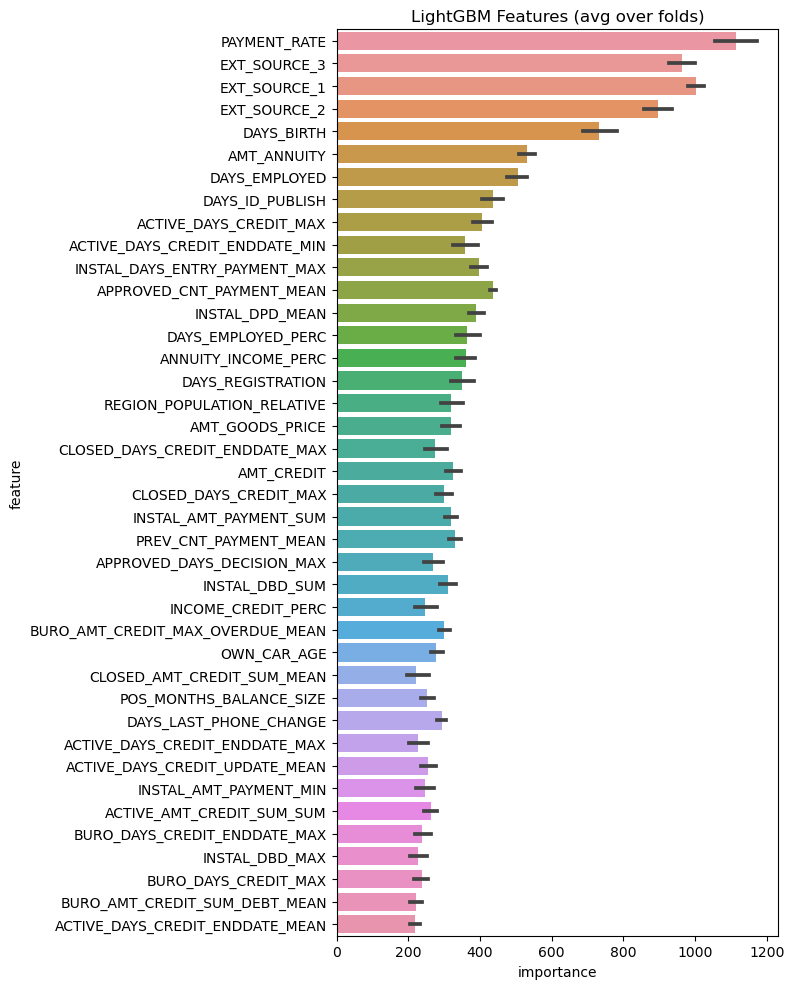

In [30]:
%%script echo skipping 

# from : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

# script légèrement modifié avec : path 


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(path + 'application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(path + 'application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(path + 'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(path + 'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path + 'previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path + 'POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path + 'installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(path + 'credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(output_path + 'lgbm_importances01.png') # modification SRV


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) # Ajout SRV suite error : [LightGBM] Do not support special JSON characters in feature name.
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

if __name__ == "__main__":
    submission_file_name = output_path + "submission_kernel02.csv" # modification SRV
    with timer("Full model run"):
        main()

---

In [4]:
import pandas as pd

In [7]:
dfsub = pd.read_csv(output_path + "submission_kernel02.csv")
dfsub.describe()

,SK_ID_CURR,TARGET
count,48744.000000,48744.000000
mean,277796.676350,0.072187
std,103169.547296,0.083051
min,100001.000000,0.002035
25%,188557.750000,0.021235
50%,277549.000000,0.041856
75%,367555.500000,0.088667
max,456250.000000,0.746969


* <span style="color:green">Installation MLFlow

* Réaliser dès le départ une analyse des données de tracking et stockage à gérer avec MLFlow : scores, autres mesures, paramètres, artifacts, modèles, …
* Créer une fonction qui standardise le tracking de données et qui sera appelée lors de chaque entraînement de modèles
* Il est attendu au minimum le tracking des scores (scores métier, AUC), des hyperparamètres, des temps de traitement de fit et de prédiction, ainsi que le stockage de graphiques (ROC curve) et des modèles
* Il est attendu un affichage des résultats via MLFlow UI

In [5]:
print(st.number_input('Revenu médian dans le secteur (en 10K de dollars)',min_value=0., value=3.87, step=1.))

3.87
